```markdown

## CNN-LSTM for Predicting Stock Price Prediction

In this problem, we will be using one type of combined architectures, CNN-LSTM to predict household power consumption from historical power consumption. The data is provided in "household_power_consumption" where we will be interested in only "Global_active_power" column. In this dataset, measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. 

Different than single time step prediction, we are now interested in predicting 60 time points (1 hour) from 600 time points (10 hours). ``` 

In [3]:

import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
import warnings
warnings.filterwarnings("ignore")


In [4]:
#Import libraries before starting
import numpy as np
import pandas as pd
from pathlib import Path

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Input,Conv1D, TimeDistributed,LSTM,Masking
from keras.callbacks import ModelCheckpoint , EarlyStopping
from keras.optimizers import Adam


from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from tqdm.keras import TqdmCallback

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
DATA_DIR = os.getenv('FINANCE_DATA_DIR', '../../data')

In [5]:
# is GPU available?
# tf.config.list_physical_devices('GPU')

In [6]:
path_to_data = Path(f'{DATA_DIR}/household_power_consumption.txt')
data = pd.read_csv(path_to_data, parse_dates =True, sep=';', nrows=10000)

# only use global_active_power column
target_col = 'Global_active_power'
data = pd.to_numeric(data[target_col], errors='coerce',)

# drop rows with missing values
data = data.dropna()

# infer data types
data = data.infer_objects()
data = data.values.reshape(-1,1)

print(data.shape)

(9998, 1)


In [7]:
# normalize data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [8]:
# helper function to create X, y 
def create_dataset(dataset, window_size = 600, predTimePoints = 60):
    """ """
    dataX, dataY = [], []
    for i in range(len(dataset) - (window_size+ predTimePoints)):
        dataX.append(dataset[i:(i + window_size)])
        dataY.append(dataset[i + window_size : i + window_size + predTimePoints, 0])
    return np.array(dataX), np.array(dataY)

In [9]:
# train and test split
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

# 
window_size = 600
predTimePoints = 60
X_train, y_train = create_dataset(train_data, window_size, predTimePoints)
X_test, y_test = create_dataset(test_data, window_size, predTimePoints)

# display shapes
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7338, 600, 1), (7338, 60), (1340, 600, 1), (1340, 60))

In [10]:
# Model 
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dense(predTimePoints))


In [11]:

# Compile the model
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='mse',metrics=['mse'])  

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 598, 32)           128       
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 60)                1980      
                                                                 
Total params: 10428 (40.73 KB)
Trainable params: 10428 (40.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# monitor = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1, patience=5, verbose=2, mode='auto')
checkpointer = ModelCheckpoint(filepath=f"models/cnn-lstm.keras", verbose=0, save_best_only=True)
tqdm_callback = TqdmCallback(verbose=1)


history = model.fit(X_train, y_train, 
                    validation_split=0.2,
                    epochs=20, 
                    batch_size=128, 
                    verbose=0,
                    callbacks=[checkpointer,tqdm_callback]
                    )

  0%|          | 0/20 [00:00<?, ?epoch/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1704703243.912949    8800 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 20/20 [00:47<00:00,  2.39s/epoch, loss=0.338, mse=0.338, val_loss=0.385, val_mse=0.385]


Text(0.5, 0, 'Epoch')

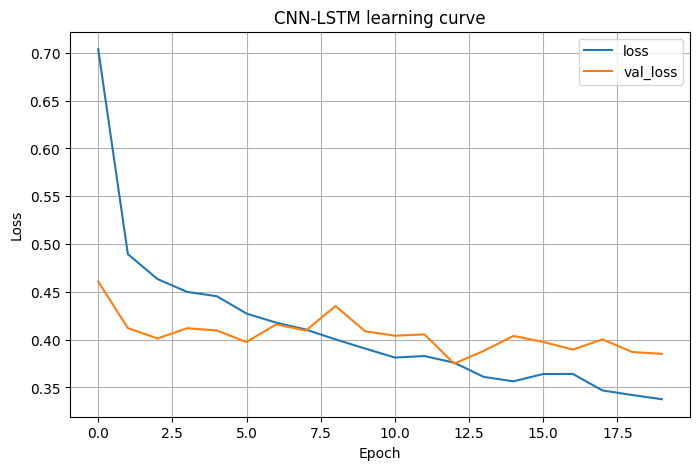

In [13]:
# Plot training & validation loss values
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(grid=True, figsize=(8,5))
plt.title('CNN-LSTM learning curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [14]:
# test set predictions
model.evaluate(X_test, y_test, verbose=2)

42/42 - 1s - loss: 1.0395 - mse: 1.0395 - 649ms/epoch - 15ms/step


[1.0395112037658691, 1.0395112037658691]

```markdown

##  NLP Transformers for Interpreting News Dataset for DJIA Direction

In this problem, we will interpret textual data via BERT and then try to predict benchmark index DJIA's direction change by just using BERT embeddings. To predict DJIA's direction from BERT embedding, we will use 'MLP with 1 hidden layer with 8 units in hidden layer'. BERT is already available in Hugging Face library.

News for each day is given in "Combined_News_DJIA.csv" and adjusted close price data of DJIA is given in "DJIA_table.csv". We can make each day a sample. Afterwards, we can use 80%-20% partition for train and test data. Note that you need to carefully tune learning rate and number of epochs. 
```

In [15]:
#Solution 2

try:
    import transformers
except:
    !pip install transformers -q
    

In [16]:
from transformers import BertTokenizer, TFBertModel
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout, Input
from keras.callbacks import ModelCheckpoint , EarlyStopping
from keras.optimizers import Adam,Nadam



In [17]:
""" helper functions"""

def merge_news_headlines(data , K=1):
    """
        Merge top(K) news headlines into one string
        data: dataframe with news 
        K: number of top news headlines to merge (1-25)
        
    """
    merged_news = data[['Top' + str(i) for i in range(1, K+1)]].apply(lambda x: ' '.join(x.astype(str)), axis=1)
    merged_news = pd.DataFrame(merged_news, columns=['news'], index=data.index)
    merged_news['label'] = data['Label']
    return merged_news


In [18]:
# load data
news_data = pd.read_csv(Path(f'{DATA_DIR}/Combined_News_DJIA.csv'), parse_dates =True,encoding='utf-8')
price_data = pd.read_csv(Path(f'{DATA_DIR}/DJIA_table.csv'), parse_dates =True,encoding='utf-8')

#len(news_data), len(price_data)
# merge news and price data
data = pd.merge(news_data, price_data, on='Date', how='inner')

# since label is given there is no need to manualy extract it from price data
# display(data.info())

# merge top k news headlines for tokenization
merged_news = merge_news_headlines(data, K=5)


In [19]:
# 
labels = merged_news['label'].values
text_inputs = merged_news['news'].values

text_inputs.shape, labels.shape

((1989,), (1989,))

In [20]:
# GET TOKENS

# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  
model = TFBertModel.from_pretrained("bert-base-uncased")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [21]:
""" works but only on small portions of data"""

# encoded_input = tokenizer(list(text_inputs), padding=True, truncation=True,  return_tensors='tf')
# # emulate small batch sizes by splitting the input into smaller batches
# output = model(encoded_input)

# # get bert embeddings
# bert_embeddings = output['last_hidden_state'][:,0,:].numpy()

' works but only on small portions of data'

In [22]:
# emulate small batches
b_size = 64
bert_embeddings = []
for i in range(0,len(list(text_inputs)),b_size):
    encoded_input = tokenizer(list(text_inputs)[i:i+b_size], padding=True, truncation=True,  return_tensors='tf')
    # emulate small batch sizes by splitting the input into smaller batches
    output = model(encoded_input)

    # get bert embeddings
    bert_embeddings.extend(output['last_hidden_state'][:,0,:].numpy())

bert_embeddings = np.array(bert_embeddings)

print(f"[INFO] Embeddings shape : {bert_embeddings.shape}")

# train test split
X_train, X_test, y_train, y_test = train_test_split(bert_embeddings, labels, test_size=0.2, random_state=42)

[INFO] Embeddings shape : (1989, 768)


In [23]:
# simple sequential model for classification
model = Sequential()
model.add(Input(shape=(bert_embeddings.shape[1],)))
model.add(Dense(8))
model.add(Dense(1, activation='sigmoid'))

# Compile 
optimizer = Nadam(lr=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
tqdm_callback = TqdmCallback(verbose=1)
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    shuffle=True,
                    epochs=100, 
                    batch_size=64, 
                    verbose=0,
                    callbacks=[tqdm_callback],
                    )

100%|██████████| 100/100 [00:12<00:00,  7.76epoch/s, loss=0.431, accuracy=0.8, val_loss=1.22, val_accuracy=0.442]  


<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>

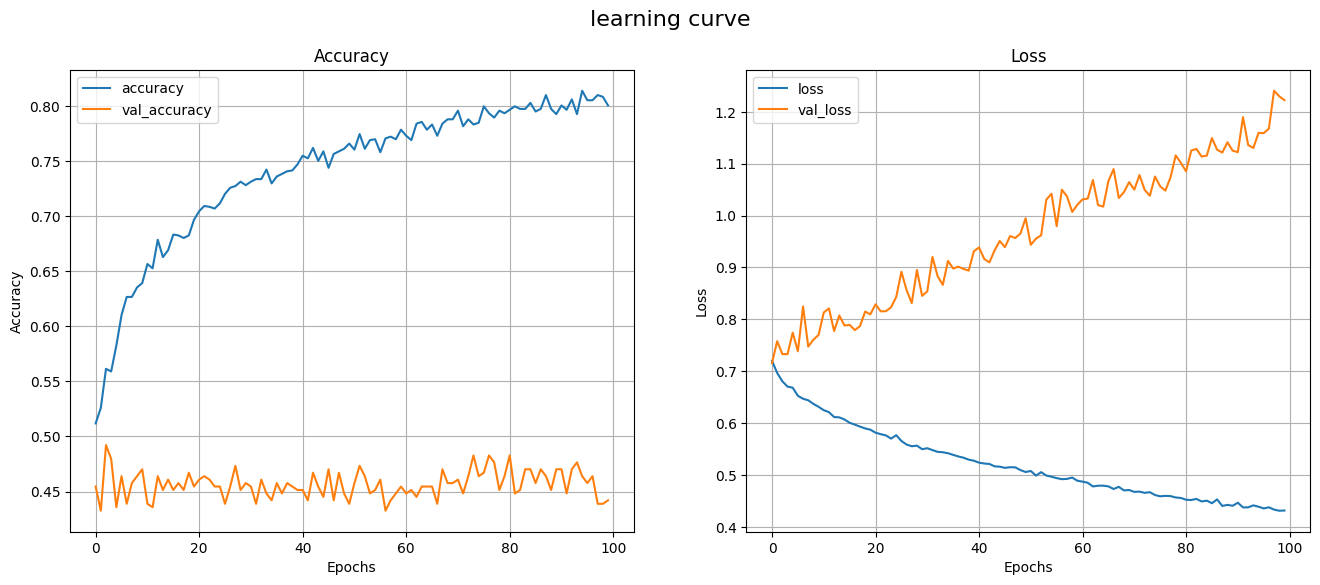

In [24]:
# plot learning curve
fig, axes = plt.subplots(1,2, figsize=(16,6))
flat_axes = axes.flatten()
fig.suptitle('learning curve', fontsize=16)
history_df = pd.DataFrame(history.history)
history_df[["accuracy", "val_accuracy"]].plot(grid=True, ax=flat_axes[0], title='Accuracy',xlabel='Epochs', ylabel='Accuracy')
history_df[["loss", "val_loss"]].plot(grid=True, ax=flat_axes[1], title='Loss',xlabel='Epochs', ylabel='Loss')



In [25]:
# evaluate model
predictions = model.evaluate(X_test, y_test, verbose=1)

13/13 [==============================] - 0s 3ms/step - loss: 0.9896 - accuracy: 0.5201


13/13 [==============================] - 0s 2ms/step
Accuracy : 0.5201005025125628


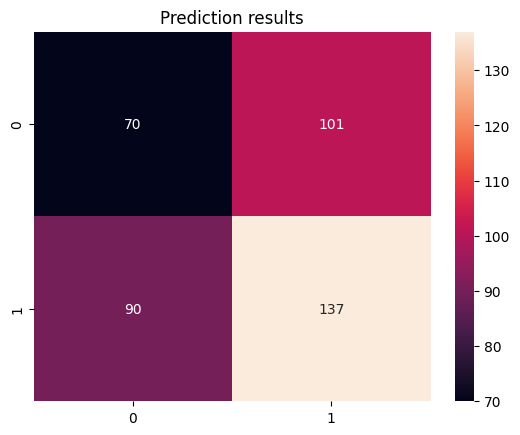

In [26]:
# plot confusion matrix
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

print(f"Accuracy : {metrics.accuracy_score(y_test, predictions)}")

#plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='g')
# plt.xlabel('Predicted')
# plt.ylabel('True')
plt.title('Prediction results')
plt.show()

```markdown

## Univariate Time-series Transformers

In this question, we try to enhance each cryptocurrency price prediction independently via time-series transformers. Close price data for BTC, ETH, LTC, SOL, AVAX, BNB is provided under "cryptoprices" directory. In each currency, we will use 2 years close price data between 2021-2023 where %80 of the data will be training data and the rest will become test dataset. We will use 60 days window to predict next 7 days (Notice that this is slightly different than predicting one time-step ahead).

We will use two time-series transformers: Informer and Autoformer. I suggest you to use Autoformer and Informer implementations in https://huggingface.co/docs/transformers.

We will try various different hyperparameter combinations for both techniques. Finally, performance of each cryptocurrency will be reported by RMSE.

```

In [28]:
# will be added